## 0.Methods and import
#### This cell contains methods and imports which are used in our analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick
from matplotlib_venn import venn2, venn3
import openpyxl
import seaborn as sns
from openpyxl import load_workbook

def accession_slice(word):
    """
    Used to only get the protein name from accession numbers generated by PEAKS X
    """
    word= word.split('|')[2]
    word=word.split(':')[0]
    word=word.split('_')[0]
    return word

def group(list):
    """
    Groups the amino acids based on polarity and acidity.
    """
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    """
    Returns the letter frequency of amino acid 1-letter abbreviations when a sequence is input
    """
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters

Normal_aminoacids={
"""
The amino acid distribution of the complete human proteome, taken from SwissProt
"""
        'A':8.25,
        'G':7.08,
        'V':6.86,
        'L':9.65,
        'I':5.92,
        'P':4.73,
        'F':3.68,
        'W':1.09,
        'M':2.41,
        'S':6.63,
        'T':5.35,
        'C':1.38,
        'Y':2.92,
        'N':4.06,
        'Q':3.93,
        'K':5.81,
        'R':5.53,
        'H':2.27,
        'D':5.46,
        'E':6.72
    }

## 1 Acute Wound Fluid Samples: 
### 1.1 Data import and dataframe construction
#### This cell generates a dataframe constituent of all sequences in the acute wound fluid samples after applying a spectral counting cut off value. It also gives some information about the general data-structure.

In [2]:

folder='peptide_sample_WF'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() 
df_tot=pd.DataFrame()  
df_mod=pd.DataFrame() 
stdev_amount=[] 
stdev_amount_mod=[] 
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]

number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))


    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))

    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('Intra sample av length: ' + str(data['Length'].mean())+' std: '+str(data['Length'].std()))
    print('Intra sample av mass: ' + str(data['Mass'].mean())+' std: '+str(data['Mass'].std()))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  

df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count WF1']=df['#Feature WF1']
df['Spectral count WF2']=df['#Feature WF2']
df['Spectral count WF3']=df['#Feature WF 3']
df['Spectral count WF4']=df['#Feature WF4']
df['Spectral count WF5']=df['#Feature WF5']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count WF1','Spectral count WF2', 'Spectral count WF3', 'Spectral count WF4','Spectral count WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("Standard deviation total # peptides: "+str(np.std(stdev_tot, ddof=1)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount, ddof=1)))
print("Inter-sample standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Inter-sample standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation # protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))


print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))


# peptides in peptide _WF1.xlsx 3687
Intra sample av length: 12.50308261405672 std: 3.6455185228680294
Intra sample av mass: 1389.8066630086312 std: 387.79677344380207
# of peptides with feat>=4 in peptide _WF1.xlsx: 811
# peptides in peptide_WF2.xlsx 4220
Intra sample av length: 12.372591006423983 std: 3.6749402412570977
Intra sample av mass: 1371.8409745360457 std: 384.9780233629806
# of peptides with feat>=4 in peptide_WF2.xlsx: 934
# peptides in peptide_WF3.xlsx 2960
Intra sample av length: 13.072222222222223 std: 3.8365239579070285
Intra sample av mass: 1439.4581251111115 std: 402.3919656880185
# of peptides with feat>=4 in peptide_WF3.xlsx: 900
# peptides in peptide_WF4.xlsx 2423
Intra sample av length: 12.95979020979021 std: 3.7965038702959246
Intra sample av mass: 1427.8018055361304 std: 399.17097386786315
# of peptides with feat>=4 in peptide_WF4.xlsx: 572
# peptides in peptide_WF5.xlsx 3367
Intra sample av length: 12.267139479905437 std: 3.3726407888450716
Intra sample av mas

## 1.2 Aminoacid profile

Text(0.5, 1.0, 'Last aminoacid')

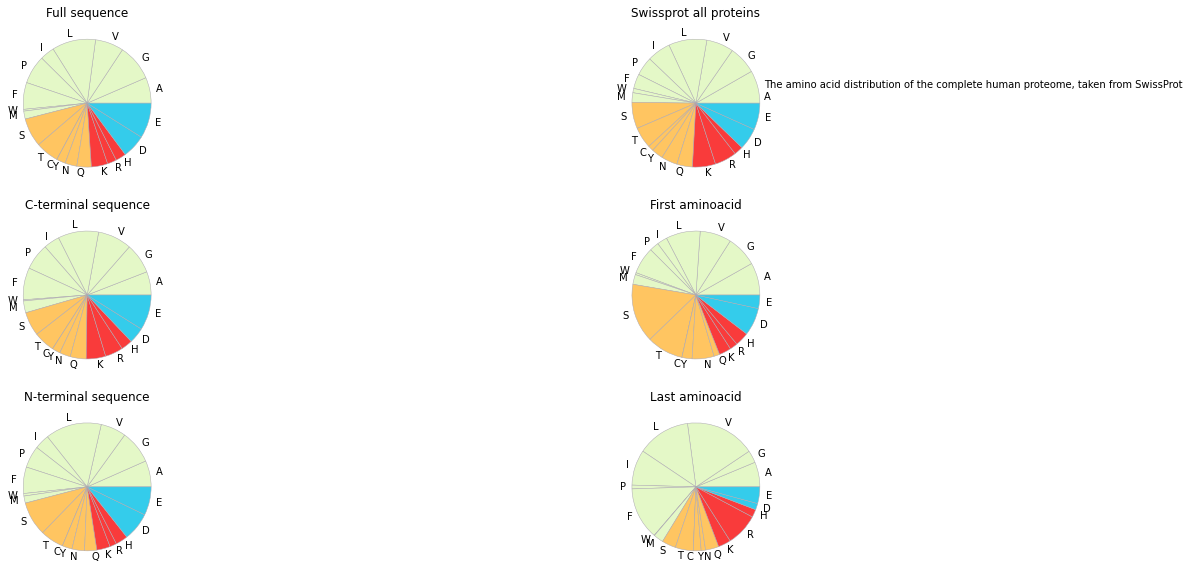

In [3]:

color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')


## 1.3 Sorted on spectral count of N/C-terminals

In [4]:

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
C-cut,,,,,,,,
KGEE,55.4,58.0,56.0,60.0,41.0,62.0,45,8.354639
RMFL,52.8,56.0,48.0,79.0,24.0,57.0,38,19.791412
FERI,48.8,50.0,57.0,37.0,35.0,65.0,42,12.853015
GEFV,45.2,48.0,46.0,57.0,42.0,33.0,47,8.757854
PDHA,41.0,50.0,59.0,44.0,25.0,27.0,28,14.713939
...,...,...,...,...,...,...,...,...
NGTV,0.8,4.0,0.0,0.0,0.0,0.0,1,1.788854
EQGR,0.8,0.0,4.0,0.0,0.0,0.0,1,1.788854
NELR,0.8,0.0,0.0,0.0,0.0,4.0,1,1.788854


### 1.4 N/C-terminal over spectral count

1210
1072


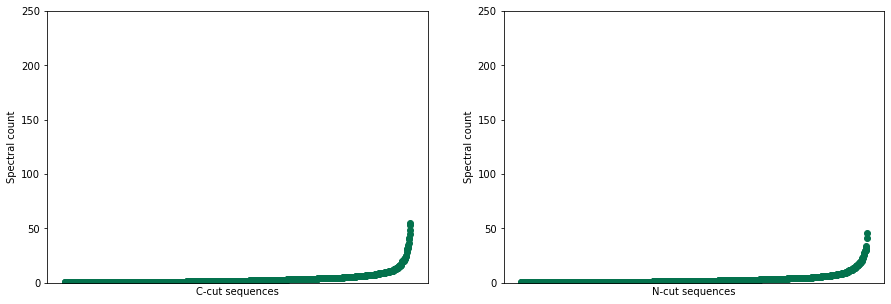

In [5]:
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
plt.setp(ax, ylim=(0,250))
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))


### 1.5 Grouped N/C-terminal tables

In [6]:


df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C= df.groupby(['C-cut']).sum()
df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_N

,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
N-grouped,,,,,,,,
PNNN,235.8,231.0,279.0,231.0,200.0,238.0,251,28.278967
NNNN,227.2,232.0,280.0,213.0,170.0,239.0,247,40.071187
NNNP,151.2,145.0,171.0,164.0,86.0,190.0,146,39.845953
NNPN,145.6,162.0,194.0,143.0,64.0,165.0,156,49.125350
PPNN,116.4,119.0,133.0,138.0,43.0,149.0,115,42.424050
...,...,...,...,...,...,...,...,...
BPPN,0.8,0.0,0.0,0.0,4.0,0.0,1,1.788854
PBNP,0.8,0.0,0.0,0.0,4.0,0.0,1,1.788854
NAPA,0.8,4.0,0.0,0.0,0.0,0.0,1,1.788854


## 1.6 Grouped N/C-terminal over spectral count

169
167


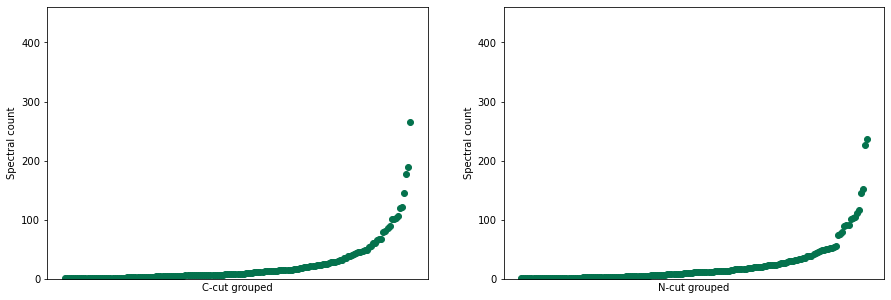

In [7]:

df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

## 2 Non-infected Samples: 
### 2.1 Data import and dataframe construction
#### This cell generates a dataframe constituent of all sequences in the acute wound fluid samples after applying a spectral counting cut off value. It also gives some information about the general data-structure.

In [8]:
mapp='peptide_sample_ninf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('Intra sample av length: ' + str(data['Length'].mean())+' std: '+str(data['Length'].std()))
    print('Intra sample av mass: ' + str(data['Mass'].mean())+' std: '+str(data['Mass'].std()))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data

df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count Sample 13']=df['#Feature Sample 13']
df['Spectral count Sample 21']=df['#Feature Sample 21']
df['Spectral count Sample 33']=df['#Feature Sample 33']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 13','Spectral count Sample 21', 'Spectral count Sample 33','count', 'N-cut', 'C-cut','First aa','Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("# total peptides mean: "+ str(np.mean(stdev_tot)) + ' std: '+str(np.std(stdev_tot, ddof=1)))
print("# peptides >=4 mean: " +str(np.mean(stdev_amount)) +' std: '+ str(np.std(stdev_amount, ddof=1)))
print("Inter-sample standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Inter-sample standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation # protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))


print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))


# peptides in peptide_sample_13.xlsx 3146
Intra sample av length: 13.041666666666666 std: 4.774990958790106
Intra sample av mass: 1402.9259897095958 std: 495.8674992567898
# of peptides with feat>=4 in peptide_sample_13.xlsx: 264
# peptides in peptide_sample_21.xlsx 4863
Intra sample av length: 12.598152424942263 std: 4.342958999905595
Intra sample av mass: 1376.3391296766742 std: 458.60693719079666
# of peptides with feat>=4 in peptide_sample_21.xlsx: 433
# peptides in peptide_sample_33.xlsx 4277
Intra sample av length: 11.355820105820106 std: 3.3250572651612846
Intra sample av mass: 1241.7114864748678 std: 343.26161116891313
# of peptides with feat>=4 in peptide_sample_33.xlsx: 756
# total peptides mean: 4095.3333333333335 std: 872.7968453960711
# peptides >=4 mean: 484.3333333333333 std: 249.9846661964156
Inter-sample standard deviation length: 0.8738967426099783
Inter-sample standard deviation mass: 86.43068464932192
Standard deviation # protein: 24.337899115029078
Average length: 

## 2.2 Aminoacid profile

Text(0.5, 1.0, 'Last aminoacid')

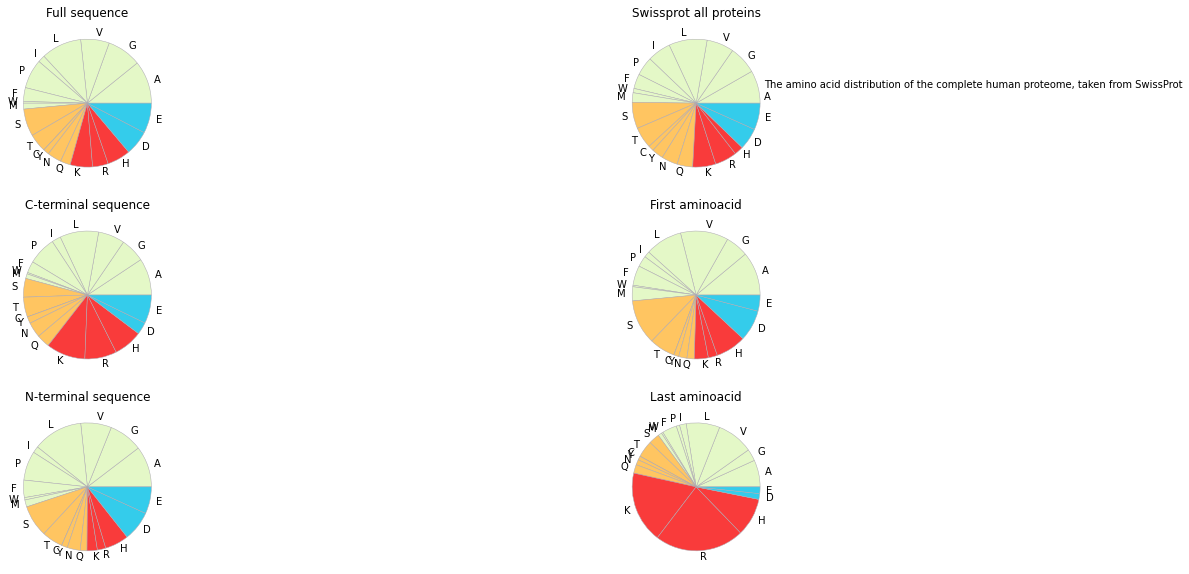

In [9]:
fig, ax = plt.subplots(3,2,figsize=(20,10))

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')


### 2.3 N,C-terminal Table

In [10]:
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
C-cut,,,,,,
LHAH,109.666667,139.0,161.0,27.0,37,71.860977
HKYH,83.666667,64.0,60.0,127.0,21,37.581024
ALER,57.666667,59.0,55.0,59.0,28,2.309401
MPNA,56.666667,50.0,58.0,62.0,22,6.110101
EITR,54.000000,32.0,65.0,64.0,12,18.770544
...,...,...,...,...,...,...
EKSA,1.333333,4.0,0.0,0.0,1,2.309401
LVQT,1.333333,0.0,0.0,4.0,1,2.309401
LVEV,1.333333,0.0,4.0,0.0,1,2.309401


### 2.4 N/C-terminal over spectral count

602
553


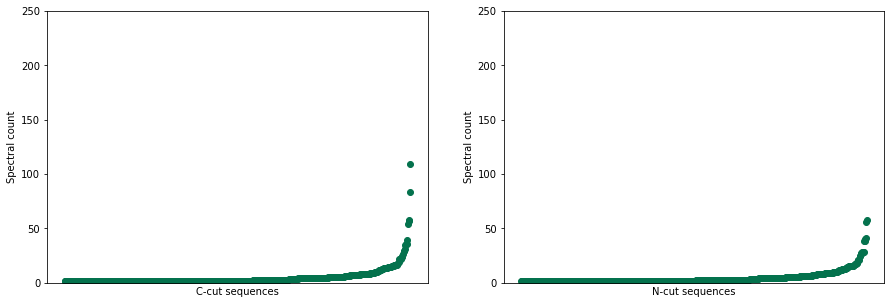

In [11]:
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.setp(ax, ylim=(0,250))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))


### 2.5 Grouped N/C-terminal table

In [12]:
df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C= df.groupby(['C-cut']).sum()
df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files

df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_N

,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,std
N-grouped,,,,,,
NNNN,153.333333,77.0,157.0,226.0,87,74.567643
NNNP,99.000000,58.0,104.0,135.0,45,38.742741
NNBN,98.000000,43.0,45.0,206.0,48,93.536089
NNPN,88.333333,56.0,70.0,139.0,47,44.433471
NNNB,88.000000,47.0,85.0,131.0,45,42.063444
...,...,...,...,...,...,...
PAPA,1.333333,0.0,0.0,4.0,1,2.309401
PBAN,1.333333,0.0,4.0,0.0,1,2.309401
PBBP,1.333333,0.0,0.0,4.0,1,2.309401


### 2.6 N/C-terminal over spectral count

150
162


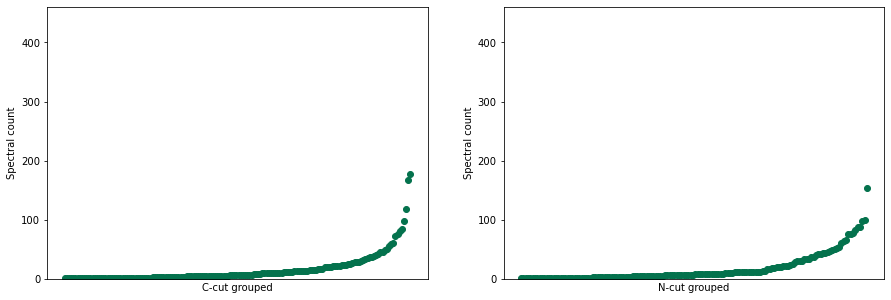

In [13]:
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

## 3 Non-infected Samples: 
### 3.1 Data import and dataframe construction
#### This cell generates a dataframe constituent of all sequences in the acute wound fluid samples after applying a spectral counting cut off value. It also gives some information about the general data-structure.

In [14]:
mapp='peptide_sample_inf'

files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))
    
    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))
    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('Intra sample av length: ' + str(data['Length'].mean())+' std: '+str(data['Length'].std()))
    print('Intra sample av mass: ' + str(data['Mass'].mean())+' std: '+str(data['Mass'].std()))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])


df['Spectral count']=df['#Feature']
df['Spectral count Sample 31']= df['#Feature Sample 31']
df['Spectral count Sample 34']=df['#Feature Sample 34']
df['Spectral count Sample 39']=df['#Feature Sample 39']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 31','Spectral count Sample 34', 'Spectral count Sample 39','count', 'N-cut', 'C-cut', 'First aa', 'Last aa']]

df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("# total peptides mean: "+ str(np.mean(stdev_tot)) + ' std: '+str(np.std(stdev_tot, ddof=1)))
print("# peptides >=4 mean: " +str(np.mean(stdev_amount)) +' std: '+ str(np.std(stdev_amount, ddof=1)))
print("Standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))

print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df

# peptides in peptide_sample_31.xlsx 5103
Intra sample av length: 12.056140350877193 std: 4.576350117924134
Intra sample av mass: 1321.1740248538015 std: 472.9634100402377
# of peptides with feat>=4 in peptide_sample_31.xlsx: 855
# peptides in peptide_sample_34.xlsx 1412
Intra sample av length: 11.115183246073299 std: 2.6172162477137375
Intra sample av mass: 1195.0327293193718 std: 264.32848797322276
# of peptides with feat>=4 in peptide_sample_34.xlsx: 191
# peptides in peptide_sample_39.xlsx 4929
Intra sample av length: 14.292706333973129 std: 6.292557286415633
Intra sample av mass: 1546.5136604126678 std: 665.0433848711396
# of peptides with feat>=4 in peptide_sample_39.xlsx: 1042
# total peptides mean: 3814.6666666666665 std: 2082.588373475021
# peptides >=4 mean: 696.0 std: 447.2258937047362
Standard deviation length: 1.6321907897035859
Standard deviation mass: 178.05824080672656
Standard deviation protein: 28.919428302325294
Average length: 13.47216349541931
Average mass: 1465.90

,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.8160,12.0,88.983333,109,37.0,12.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.6890,9.0,70.753333,94,33.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|P00738|HPT_HUMAN,NFKFTDHLKYVMLPV,1866.9702,15.0,109.220000,4,4.0,0.0,0.0,1,NFKF,MLPV,N,V
sp|P00738|HPT_HUMAN,TSIQDWVQKTIAEN,1631.8154,14.0,115.070000,4,0.0,4.0,0.0,1,TSIQ,IAEN,T,N
sp|P00558|PGK1_HUMAN,EGKVLPGVDAL,1096.6128,11.0,83.750000,4,0.0,0.0,4.0,1,EGKV,VDAL,E,L


### 3.2 Amino acid profile

Text(0.5, 1.0, 'Last aminoacid')

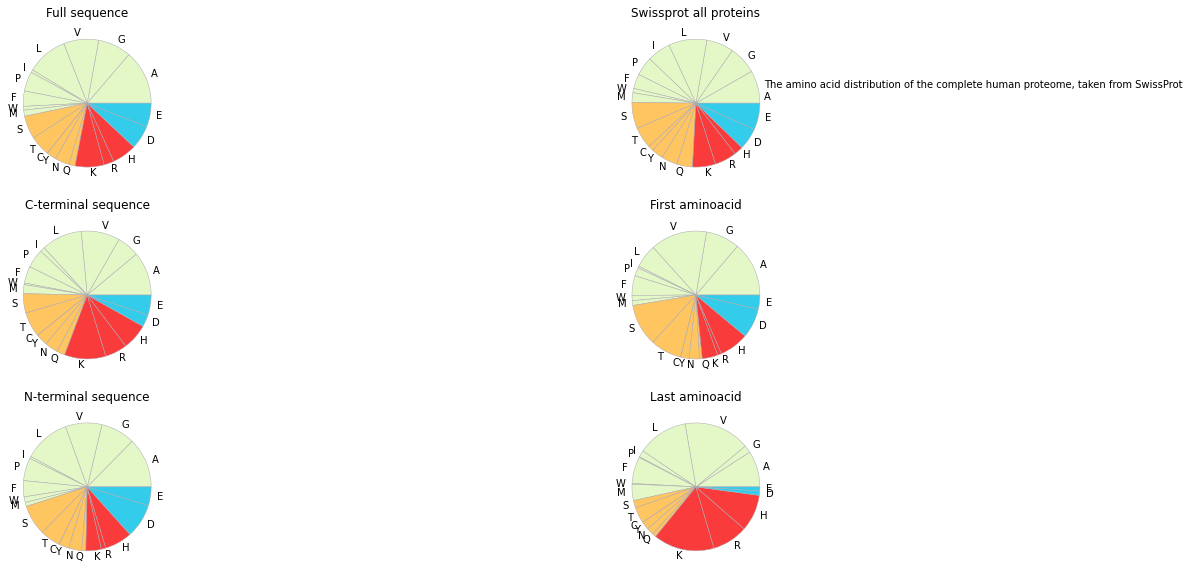

In [15]:
fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')


### 3.3 N/C-terminal table

In [16]:
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
C-cut,,,,,,
HKYH,238.000000,215.0,49.0,450.0,39,201.486972
LERM,170.000000,215.0,9.0,286.0,32,143.878421
SKYR,130.333333,105.0,40.0,246.0,35,105.310652
LSAL,124.666667,131.0,28.0,215.0,34,93.660735
GTFA,113.333333,141.0,20.0,178.0,35,82.637764
...,...,...,...,...,...,...
HLPA,1.333333,4.0,0.0,0.0,1,2.309401
HHKP,1.333333,4.0,0.0,0.0,1,2.309401
QFPI,1.333333,4.0,0.0,0.0,1,2.309401


### 3.4 N/C-terminal over spectral count

589
561


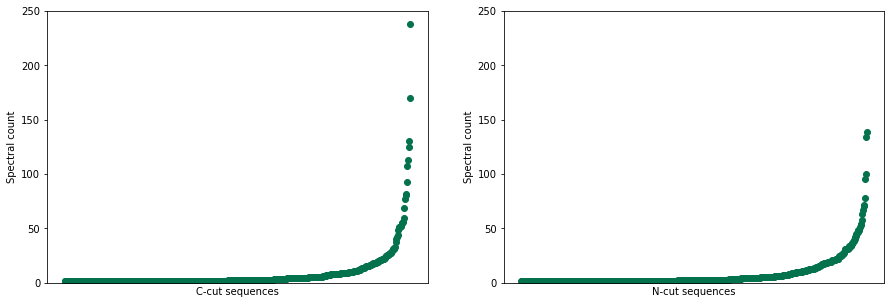

In [17]:
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')

fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.setp(ax, ylim=(0,250))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

### 3.5 Grouped N/C-terminal table

In [18]:


df_N= df.groupby(['N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['Spectral count'], ascending=False) #sorts these values by count and feature
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead
df_N['Spectral count']=df_N['Spectral count']/number_of_files

df_N=df_N.sort_values(['Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C= df.groupby(['C-cut']).sum()
df_C = df_C.sort_values(['Spectral count'], ascending=False)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.groupby(['C-grouped']).sum()
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_N

,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,std
N-grouped,,,,,,
NNPN,238.333333,301.0,64.0,350.0,88,152.952062
NNBN,222.333333,305.0,34.0,328.0,95,163.506371
NNNB,207.333333,249.0,50.0,322.0,83,140.779970
NBNP,192.000000,222.0,57.0,297.0,73,122.780292
PPNN,175.333333,223.0,40.0,263.0,61,118.896313
...,...,...,...,...,...,...
NPAB,1.333333,4.0,0.0,0.0,1,2.309401
BBBN,1.333333,4.0,0.0,0.0,1,2.309401
PBPN,1.333333,0.0,0.0,4.0,1,2.309401


### 3.6 Grouped N/C-terminal over spectral count

159
147


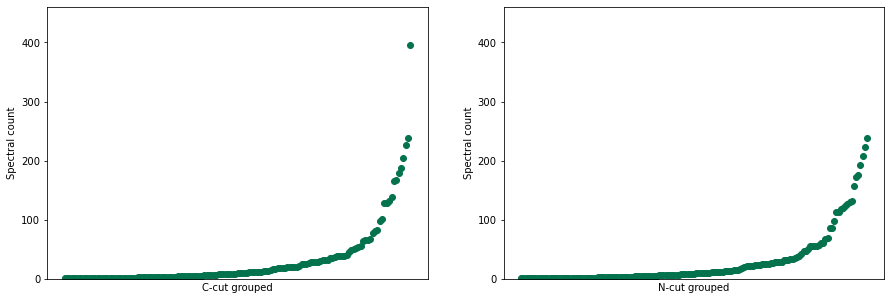

In [19]:
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

## 4 Group analysis
### 4.1 Import data and create dataframes

In [20]:
folder='peptide_sample_WF'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
WF_samples=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_WF = df_WF.append(data)  # appends all data
    print(file+': '+str(len(data['Peptide'])))
    WF_samples.append(data['Peptide'])

folder='peptide_sample_ninf'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
non_inf_patients=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_ninf = df_ninf.append(data)  # appends all data
    non_inf_patients.append(data['Peptide'])

folder='peptide_sample_inf'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
inf_patients=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_inf = df_inf.append(data)  # appends all data
    inf_patients.append(data['Peptide'])

df_ninf['count'] = 1
df_WF['count'] = 1
df_inf['count']=1

g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

color=[r,p,y]

peptide _WF1.xlsx: 811
peptide_WF2.xlsx: 934
peptide_WF3.xlsx: 900
peptide_WF4.xlsx: 572
peptide_WF5.xlsx: 846


### 4.2 Non-infected samples venn diagram

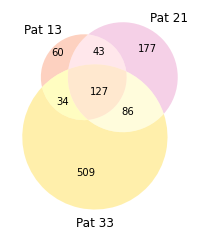

In [21]:
venn3([set(non_inf_patients[0]),set(non_inf_patients[1]),set(non_inf_patients[2])], set_labels=('Pat 13','Pat 21','Pat 33'), set_colors=color)

### 4.3 Infected samples venn diagram

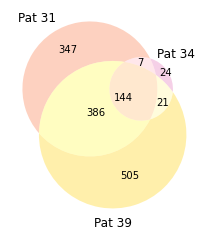

In [22]:
venn3([set(inf_patients[0]),set(inf_patients[1]),set(inf_patients[2])], set_labels=('Pat 31', 'Pat 34','Pat 39'), set_colors=color)

### 4.4 Difference table

In [23]:
df_WF_all=pd.DataFrame()
df_WF_all['Peptide']=df_WF['Peptide']
df_WF = df_WF.groupby(['Accession','Peptide']).sum()
df_WF.reset_index(['Peptide'], inplace=True)
df_WF = df_WF[['Peptide', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count']]
df_WF = df_WF.sort_values(['count','#Feature'], ascending=False)


df_ninf_all=pd.DataFrame()
df_ninf_all['Peptide']=df_ninf['Peptide']

df_ninf = df_ninf.groupby(['Accession','Peptide']).sum()
df_ninf.reset_index(['Peptide'], inplace=True)
df_ninf = df_ninf[['Peptide','#Feature','#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33','count',]]
df_ninf = df_ninf.sort_values(['count','#Feature'], ascending=False)

#infected patients
df_inf_all=pd.DataFrame()
df_inf_all['Peptide']=df_inf['Peptide']

df_inf = df_inf.groupby(['Accession','Peptide']).sum()
df_inf.reset_index(['Peptide'], inplace=True)
df_inf = df_inf[['Peptide','#Feature','#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39','count',]]
df_inf = df_inf.sort_values(['count','#Feature'], ascending=False)

df_ninf_same=df_ninf.loc[(df_ninf['count']==3)]
df_WF_same=df_WF.loc[(df_WF['count']==5)]
df_inf_same=df_inf.loc[(df_inf['count']==3)]

df_WF_ninf=df_WF_same.append(df_ninf_same)
df_WF_ninf.reset_index()
df_WF_ninf=df_WF_ninf.groupby(['Accession','Peptide']).sum()
df_WF_ninf.sort_values(['count','#Feature'], ascending=False)

df_ninf_inf=df_ninf_same.append(df_inf_same)
df_ninf_inf.reset_index()
df_ninf_inf=df_ninf_inf.groupby(['Accession','Peptide']).sum()
df_ninf_inf=df_ninf_inf.sort_values(['count','#Feature'], ascending=False)
df_ninf_inf['Fold Change']=(df_ninf_inf['#Feature Sample 31']+df_ninf_inf['#Feature Sample 34']+df_ninf_inf['#Feature Sample 39'])/(df_ninf_inf['#Feature Sample 13']+df_ninf_inf['#Feature Sample 21']+df_ninf_inf['#Feature Sample 33'])
df_ninf_inf['Difference (ninf-inf)']=((df_ninf_inf['#Feature Sample 13']+df_ninf_inf['#Feature Sample 21']+df_ninf_inf['#Feature Sample 33'])/3)-((df_ninf_inf['#Feature Sample 31']+df_ninf_inf['#Feature Sample 34']+df_ninf_inf['#Feature Sample 39'])/3)
df_ninf_inf=df_ninf_inf.sort_values(['Difference (ninf-inf)'], ascending=True)
df_ninf_inf.reset_index(inplace=True)
df_ninf_inf['std ninf']=df_ninf_inf[['#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33']].std(axis = 1, ddof=1, skipna = True) 
df_ninf_inf['std inf']=df_ninf_inf[['#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39']].std(axis = 1, ddof=1, skipna = True)
df_ninf_inf

,Accession,Peptide,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,Fold Change,Difference (ninf-inf),std ninf,std inf
0,sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,150,11.0,12.0,18.0,6,37.0,12.0,60.0,2.658537,-22.666667,3.785939,24.006943
1,sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,152,13.0,13.0,17.0,6,42.0,12.0,55.0,2.534884,-22.000000,2.309401,22.052967
2,sp|P68871|HBB_HUMAN,SDGLAHLDNLKGTFA,56,0.0,0.0,0.0,3,22.0,6.0,28.0,inf,-18.666667,0.000000,11.372481
3,sp|P68871|HBB_HUMAN,VHLTPEEKSAV,102,8.0,8.0,8.0,6,28.0,14.0,36.0,3.250000,-18.000000,0.000000,11.135529
4,sp|P69905|HBA_HUMAN,AHVDDMPNALSAL,54,0.0,0.0,0.0,3,22.0,13.0,19.0,inf,-18.000000,0.000000,4.582576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,sp|P69905|HBA_HUMAN,LTNAVAHVDDMPNA,29,8.0,9.0,12.0,3,0.0,0.0,0.0,0.000000,9.666667,2.081666,0.000000
196,sp|P69905|HBA_HUMAN,ALTNAVAHVDDMPNA,31,9.0,14.0,8.0,3,0.0,0.0,0.0,0.000000,10.333333,3.214550,0.000000
197,sp|P69905|HBA_HUMAN,LTNAVAHVDDMPNALSALSDLHAH,35,16.0,14.0,5.0,3,0.0,0.0,0.0,0.000000,11.666667,5.859465,0.000000
198,sp|P02671|FIBA_HUMAN,MELERPGGNEIT,62,16.0,32.0,13.0,3,0.0,0.0,0.0,0.000000,20.333333,10.214369,0.000000


### 4.5 Between-group venn

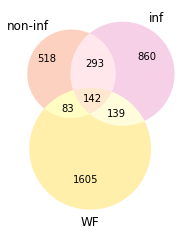

In [24]:
v=venn3([set(df_ninf['Peptide']), set(df_inf['Peptide']), set(df_WF['Peptide'])], set_labels = ('non-inf', 'inf', 'WF'), set_colors=color)


## 5 Heatmap
### 5.1 Import data and create dataframes

In [25]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['Accession']=data['Accession'].apply(lambda x: accession_slice(x))
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_inf = df_inf.append(data)


df_inf['count']=1
df_inf= df_inf.groupby(['Peptide'], as_index=False).sum()
df_inf = df_inf[['Peptide','#Feature','#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39','count',]]
df_inf = df_inf.sort_values(['Peptide'])


mapp='peptide_sample_WF'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Accession']=data['Accession'].apply(lambda x: accession_slice(x))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_WF = df_WF.append(data)


df_WF['count']=1
df_WF= df_WF.groupby(['Peptide'], as_index=False).sum()
df_WF = df_WF[['Peptide', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count']]
df_WF = df_WF.sort_values(['Peptide'])
df_WF

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Accession']=data['Accession'].apply(lambda x: accession_slice(x))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_ninf = df_ninf.append(data)


df_ninf['count']=1
df_ninf= df_ninf.groupby(['Peptide'], as_index=False).sum()
df_ninf = df_ninf[['Peptide','#Feature','#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33','count',]]
df_ninf = df_ninf.sort_values(['Peptide'])
df_inf

,Peptide,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
0,AAHLPAEF,4,4.0,0.0,0.0,1
1,AAHLPAEFTPA,8,4.0,0.0,4.0,2
2,AAHLPAEFTPAV,12,4.0,4.0,4.0,3
3,AAHLPAEFTPAVH,19,7.0,4.0,8.0,3
4,AAHLPAEFTPAVHA,23,8.0,4.0,11.0,3
...,...,...,...,...,...,...
1395,YQKVVAGVAN,4,0.0,0.0,4.0,1
1396,YQKVVAGVANA,4,0.0,0.0,4.0,1
1397,YQKVVAGVANAL,8,4.0,0.0,4.0,2
1398,YQKVVAGVANALA,4,4.0,0.0,0.0,1


### 5.2 Import heatmap.xlsx and construct dataframes and antimicrobial score sum/mean/std

In [26]:
heatmap_inf=pd.read_excel('heatmap.xlsx',sheet_name='inf')
heatmap_ninf=pd.read_excel('heatmap.xlsx',sheet_name='ninf')
heatmap_WF=pd.read_excel('heatmap.xlsx',sheet_name='WF')

heatmap_ninf=heatmap_ninf.rename(columns={'Seq':'Peptide'})
heatmap_inf=heatmap_inf.rename(columns={'Seq':'Peptide'})
heatmap_WF=heatmap_WF.rename(columns={'Seq':'Peptide'})
heatmap_inf=heatmap_inf.merge(df_inf, on='Peptide', how='inner')
heatmap_ninf=heatmap_ninf.merge(df_ninf, on='Peptide', how='inner')
heatmap_WF=heatmap_WF.merge(df_WF, on='Peptide', how='inner')
heatmap_inf.head()
cutoff=0.7
heatmap_WF=heatmap_WF.loc[(heatmap_WF['Deep-AmPEP30']>=cutoff)]
heatmap_inf=heatmap_inf.loc[(heatmap_inf['Deep-AmPEP30']>=cutoff)]
heatmap_ninf=heatmap_ninf.loc[(heatmap_ninf['Deep-AmPEP30']>=cutoff)]
heatmap_inf.sort_values('#Feature', ascending=False)

heatmap_inf['AMS1']=heatmap_inf['#Feature Sample 31']*heatmap_inf['Deep-AmPEP30']
heatmap_inf['AMS2']=heatmap_inf['#Feature Sample 34']*heatmap_inf['Deep-AmPEP30']
heatmap_inf['AMS3']=heatmap_inf['#Feature Sample 39']*heatmap_inf['Deep-AmPEP30']

heatmap_ninf['AMS1']=heatmap_ninf['#Feature Sample 13']*heatmap_ninf['Deep-AmPEP30']
heatmap_ninf['AMS2']=heatmap_ninf['#Feature Sample 21']*heatmap_ninf['Deep-AmPEP30']
heatmap_ninf['AMS3']=heatmap_ninf['#Feature Sample 33']*heatmap_ninf['Deep-AmPEP30']

heatmap_WF['AMS1']=heatmap_WF['#Feature WF1']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS2']=heatmap_WF['#Feature WF2']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS3']=heatmap_WF['#Feature WF 3']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS4']=heatmap_WF['#Feature WF4']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS5']=heatmap_WF['#Feature WF5']*heatmap_WF['Deep-AmPEP30']

ninf_std=heatmap_ninf.copy()
ninf_std=ninf_std[['AMS1', 'AMS2','AMS3']]
heatmap_ninf['std']=ninf_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_ninf['mean AMS']=ninf_std.mean(axis=1, numeric_only=True)
heatmap_ninf=heatmap_ninf.sort_values('mean AMS', ascending=False)

WF_std=heatmap_WF.copy()
WF_std=WF_std[['AMS1', 'AMS2','AMS3','AMS4','AMS5']]
heatmap_WF['std']=WF_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_WF['mean AMS']=WF_std.mean(axis=1, numeric_only=True)
heatmap_WF=heatmap_WF.sort_values('mean AMS', ascending=False)

inf_std=heatmap_inf.copy()
inf_std=inf_std[['AMS1', 'AMS2','AMS3']]
heatmap_inf['std']=inf_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_inf['mean AMS']=inf_std.mean(axis=1, numeric_only=True)
heatmap_inf=heatmap_inf.sort_values('mean AMS', ascending=False)

amount_of_sequences=50

WF_AMS1=heatmap_WF['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
WF_AMS2=heatmap_WF['AMS2'].sort_values(ascending=False)[0:50]
WF_AMS3=heatmap_WF['AMS3'].sort_values(ascending=False)[0:50]
WF_AMS4=heatmap_WF['AMS4'].sort_values(ascending=False)[0:50]
WF_AMS5=heatmap_WF['AMS5'].sort_values(ascending=False)[0:50]

inf_AMS1=heatmap_inf['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
inf_AMS2=heatmap_inf['AMS2'].sort_values(ascending=False)[0:amount_of_sequences]
inf_AMS3=heatmap_inf['AMS3'].sort_values(ascending=False)[0:amount_of_sequences]

ninf_AMS1=heatmap_ninf['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
ninf_AMS2=heatmap_ninf['AMS2'].sort_values(ascending=False)[0:amount_of_sequences]
ninf_AMS3=heatmap_ninf['AMS3'].sort_values(ascending=False)[0:amount_of_sequences]

AMS1=sum(heatmap_WF['AMS1'])
AMS2=sum(heatmap_WF['AMS2'])
AMS3=sum(heatmap_WF['AMS3'])
AMS4=sum(heatmap_WF['AMS4'])
AMS5=sum(heatmap_WF['AMS5'])
print('WF: ',AMS1, AMS2, AMS3, AMS4, AMS5)

AMS_mean=np.mean([AMS1, AMS2, AMS3, AMS4, AMS5])
AMS_std=np.std([AMS1, AMS2, AMS3, AMS4, AMS5], ddof=1)
print(AMS_mean, AMS_std)

AMS1=sum(heatmap_inf['AMS1'])
AMS2=sum(heatmap_inf['AMS2'])
AMS3=sum(heatmap_inf['AMS3'])

print('Infected: ',AMS1, AMS2, AMS3)

AMS_mean=np.mean([AMS1, AMS2, AMS3])
AMS_std=np.std([AMS1, AMS2, AMS3], ddof=1)
print(AMS_mean, AMS_std)

AMS1=sum(heatmap_ninf['AMS1'])
AMS2=sum(heatmap_ninf['AMS2'])
AMS3=sum(heatmap_ninf['AMS3'])

print('Non-infected: ',AMS1, AMS2, AMS3)

AMS_mean=np.mean([AMS1, AMS2, AMS3])
AMS_std=np.std([AMS1, AMS2, AMS3], ddof=1)
print(AMS_mean, AMS_std)

WF:  164.70652399999997 154.49354900000003 121.88631500000001 68.78301599999999 129.28122199999999
127.8301252 37.399206621559394
Infected:  709.641828 72.95069499999998 613.0255310000003
465.20601800000014 343.12076012371193
Non-infected:  98.75932100000001 134.054304 344.92224099999993
192.578622 133.10848073565947


### 5.3 Create heatmap

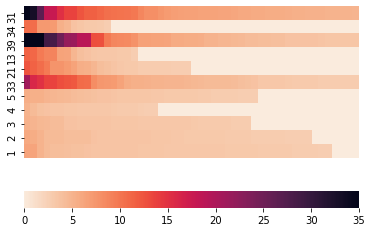

In [27]:
ytick=['31','34','39','13','21','33','5','4','3','2','1'] #sample order
ax = sns.heatmap([inf_AMS1, inf_AMS2, inf_AMS3,ninf_AMS1, ninf_AMS2, ninf_AMS3, WF_AMS5, WF_AMS4, WF_AMS3, WF_AMS2, WF_AMS1], vmin=0, vmax=35,cmap="rocket_r", yticklabels=ytick, xticklabels=False, cbar_kws={"orientation": "horizontal"})
fig = ax.get_figure()

# 6 Antimicrobial protein substrates and piecharts
### 6.1 Infected

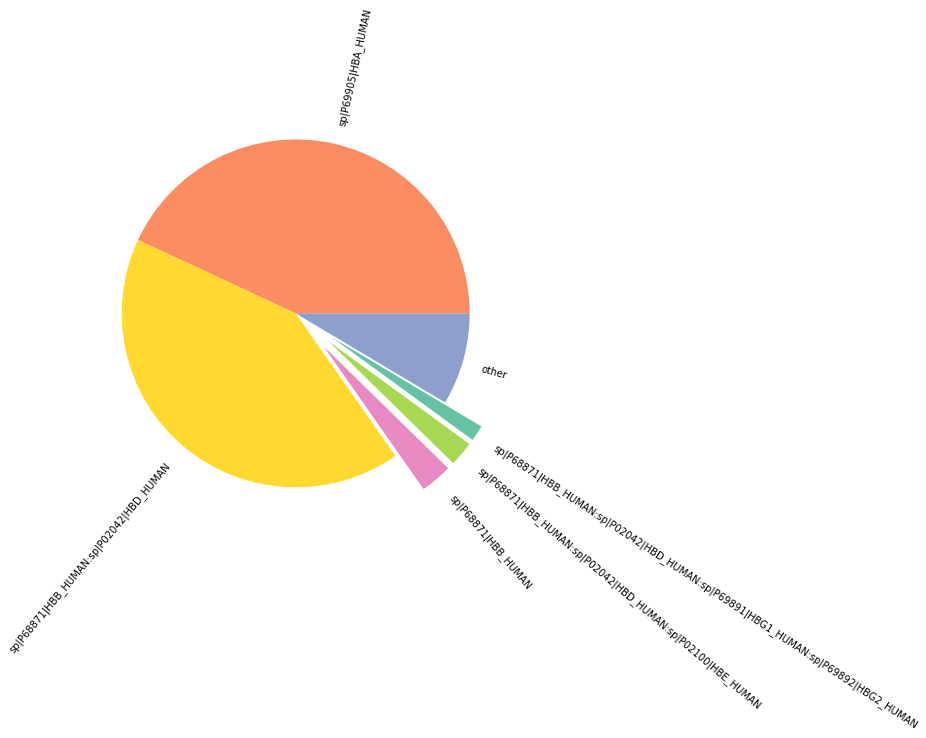

In [34]:
sheet='inf'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
cutoff=0.7
df=df.loc[(df['Deep-AmPEP30']>=cutoff)]
df=df[['Accession', '#Feature','Feature*Ampep,deep', 'Deep-AmPEP30']]
           

df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['#Feature'])
other =df_misc['#Feature'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[r,y,p,lg,g,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.5,0.5,0.5,0], radius=2, colors=colors) 
plt.show()

### 6.2 Non-infected

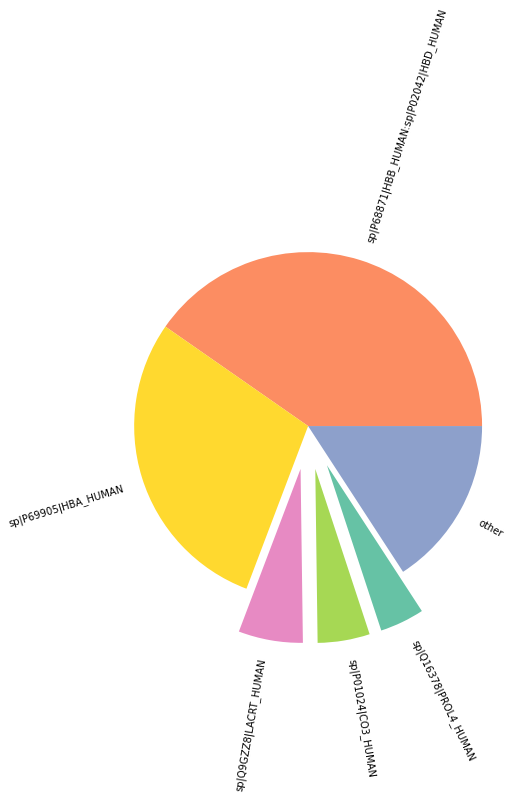

In [35]:
sheet='ninf'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
df=df.loc[(df['Deep-AmPEP30']>=cutoff)]
df=df[['Accession', '#Feature','Feature*Ampep,deep', 'Deep-AmPEP30']]
df['#Feature'].sum()
df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['#Feature'])
other =df_misc['#Feature'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[r,y,p,lg,g,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.5,0.5,0.5,0], radius=2, colors=colors) 
plt.show()

### 6.3 Acute Wound Fluid

([<matplotlib.patches.Wedge at 0x1732cf13b48>,
 [Text(0.8991580762508219, 2.0078632308782693, 'sp|P02671|FIBA_HUMAN'),
  Text(-2.099364204774883, 0.6577765089374382, 'sp|P69905|HBA_HUMAN'),
  Text(-2.0849082144010533, -1.188763112450505, 'sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN'),
  Text(-1.296794913372179, -2.0194858139269125, 'sp|P01009|A1AT_HUMAN'),
  Text(-0.6803947356812716, -2.301534923405946, 'sp|P02647|APOA1_HUMAN'),
  Text(1.3904949916980804, -1.704852978430268, 'other')])

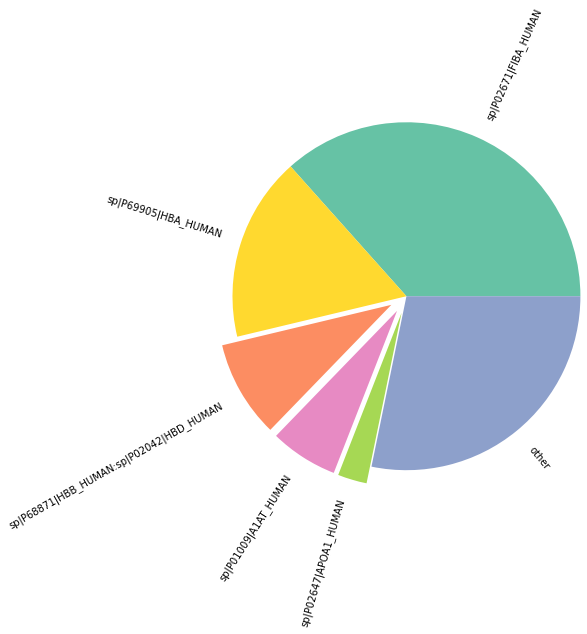

In [36]:
sheet='WF'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
df=df.loc[(df['Deep-AmPEP30']>=cutoff)]
df=df[['Accession', 'Spectral count','Feature*Ampep,deep', 'Deep-AmPEP30']]
df['Spectral count'].sum()


df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['Spectral count'])
other =df_misc['Spectral count'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[g,y,r,p,lg,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.2,0.2,0.2,0], radius=2, colors=colors) 

# 7 Protein substrate for peptides
### 7.1 Acute Wound Fluid

Text(0.5, 1.0, 'WF')

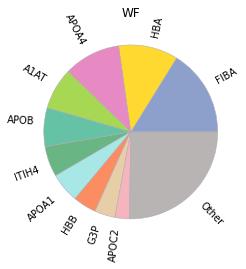

In [37]:
g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

rc1=('#69b584')
rc2=('#a7e8e7')
rc3=('#e8cea7')
rc4=('#f5b5bf')
rc5=('#b8b4b4')

mapp='peptide_sample_WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_misc.sum()
len(df_imp)
test =(list(df_imp.keys()))
test.append('Other')

WF_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(list(df_list_imp),labels = test , wedgeprops=wp, rotatelabels=True, colors=WF_colors) 
plt.title('WF')


### 7.2 Infected

Text(0.5, 1.0, 'Infected')

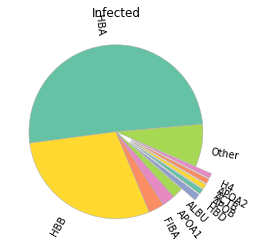

In [40]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_misc.sum()
len(df_imp)
test =(list(df_imp.keys()))
test.append('Other')
inf_colors=[y,r,l,p,lg,g,rc1,rc2,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(list(df_list_imp),labels = test , wedgeprops=wp, rotatelabels=True, explode=[0,0,0,0,0,0.2,0.2,0.2,0.2,0.2,0],colors=colors,startangle= 5 ) 
plt.title('Infected')

### 7.3 Non-infected

Text(0.5, 1.0, 'Non-infected')

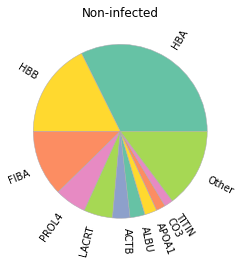

In [41]:

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_misc.sum()
len(df_imp)
test =(list(df_imp.keys()))
test.append('Other')

ninf_colors=[y,r,l,p,lg,g,rc1,rc2,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
plt.pie(list(df_list_imp),labels = test , wedgeprops=wp, rotatelabels=True, colors=colors) 
plt.title('Non-infected')


## 8 Literature search

### 8.1 Searching the data

In [ ]:
mapp='Alla'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_all = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data = data.loc[(data['#Feature'] >= 4)]
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    df_all = df_all.append(data)
    filename='data_litterature.xlsx'
sheetname='13'
df_ref=pd.read_excel(filename, sheet_name=sheetname)
df_ref.dropna(subset=['Peptide'], inplace=True)
df_ref
result=[]
for seq1 in df_ref['Peptide']:
    for seq2 in df_all['Peptide']:
        if seq1 in seq2 and len(seq2)<(len(seq1)+6):
            result.append((seq1,seq2))            
result

### 8.2 Spectral counting


In [ ]:
files = os.listdir('protein-peptide_sample_inf')
files_xls = [f for f in files if f[-3:] == 'lsx']
df_inf = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('protein-peptide_sample_inf' + '/' + f)
    data = data.loc[(data['#Feature'] >= 4)]
    data['Peptide']= data['Peptide'].str.replace('\d+', '')
    data['Peptide']= data['Peptide'].str.replace(r'\(\+\.\)', '')
    data['Peptide']= data['Peptide'].apply(lambda x: x.split('.')[1] if x[1]=='.' else x.split('.')[0] if (x[1]!='.' and x[-2]=='.') else x)
    data['count'] = 1
    data = data.groupby(by=['Peptide', 'Protein Accession'], as_index=False).sum()
    data['End'] = data['End']/ data['count']
    data['Start'] = data['Start']/ data['count']
    df_inf = df_inf.append(data)
df_inf['count']=1
df_inf = df_inf.groupby(by=['Peptide','Protein Accession'], as_index=False).sum()
df_inf['End']=df_inf['End']/df_inf['count']
df_inf['Start']=df_inf['Start']/df_inf['count']
df_inf=df_inf.drop(columns='count')
df_inf = df_inf [['Peptide','Protein Accession', 'Start','End', '#Feature']]    
files = os.listdir('protein-peptide_sample_ninf')
files_xls = [f for f in files if f[-3:] == 'lsx']
df_ninf = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('protein-peptide_sample_ninf' + '/' + f)
    data = data.loc[(data['#Feature'] >= 4)]
    data['Peptide']= data['Peptide'].str.replace('\d+', '')
    data['Peptide']= data['Peptide'].str.replace(r'\(\+\.\)', '')
    data['Peptide']= data['Peptide'].apply(lambda x: x.split('.')[1] if x[1]=='.' else x.split('.')[0] if (x[1]!='.' and x[-2]=='.') else x)
    data['count'] = 1
    data = data.groupby(by=['Peptide', 'Protein Accession'], as_index=False).sum()
    data['End'] = data['End']/ data['count']
    data['Start'] = data['Start']/ data['count']
    df_ninf = df_ninf.append(data)
df_ninf['count']=1
df_ninf = df_ninf.groupby(by=['Peptide','Protein Accession'], as_index=False).sum()
df_ninf['End']=df_ninf['End']/df_ninf['count']
df_ninf['Start']=df_ninf['Start']/df_ninf['count']
df_ninf=df_ninf.drop(columns='count')
df_ninf = df_ninf [['Peptide','Protein Accession', 'Start','End', '#Feature']]    
files = os.listdir('protein-peptide_sample_wf')
files_xls = [f for f in files if f[-3:] == 'lsx']
df_wf = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('protein-peptide_sample_wf' + '/' + f)
    data = data.loc[(data['#Feature'] >= 4)]
    data['Peptide']= data['Peptide'].str.replace('\d+', '')
    data['Peptide']= data['Peptide'].str.replace(r'\(\+\.\)', '')
    data['Peptide']= data['Peptide'].apply(lambda x: x.split('.')[1] if x[1]=='.' else x.split('.')[0] if (x[1]!='.' and x[-2]=='.') else x)
    data['count'] = 1
    data = data.groupby(by=['Peptide', 'Protein Accession'], as_index=False).sum()
    data['End'] = data['End']/ data['count']
    data['Start'] = data['Start']/ data['count']
    df_wf = df_wf.append(data)
df_wf = df_wf.groupby(by=['Peptide','Protein Accession'], as_index=False).sum()
df_wf['End']=df_wf['End']/df_wf['count']
df_wf['Start']=df_wf['Start']/df_wf['count']
df_wf=df_wf.drop(columns='count')
df_wf = df_wf [['Peptide','Protein Accession', 'Start','End', '#Feature']]

Protein='sp|P69905|HBA_HUMAN'
Start=33
End=76
df_wf_start=df_wf.loc[(df_wf['Start']>=Start)]
df_wf_end=df_wf_start.loc[(df_wf_start['End']<=End)]
df_wf_end=df_wf_end.loc[(df_wf_end['Protein Accession']==Protein)]
print(df_wf_end['#Feature'].sum())
print(df_wf_end)

# Supplementary

## S.1 Exclude HB proteins
### S.1.1 Acute Wound Fluid

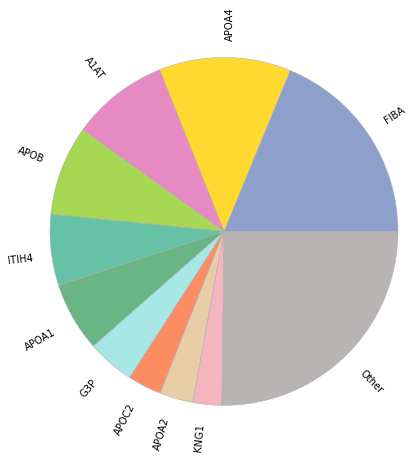

In [42]:

folder='peptide_sample_WF'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
df = df.drop(['HBB','HBA','HBD'])

tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_list_imp


keys =(list(df_imp.keys()))
keys.append('Other')


WF_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
pie=plt.pie(list(df_list_imp),labels = keys , wedgeprops=wp, rotatelabels=True, colors=WF_colors, radius=2) 


### S.1.2 Infected

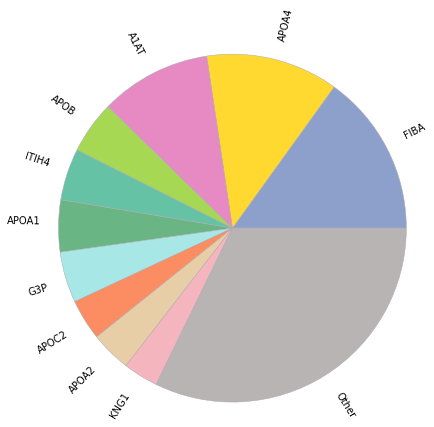

In [43]:
folder='peptide_sample_inf'
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
df = df.drop(['HBB','HBA','HBD'])

tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)


inf_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
pie=plt.pie(list(df_list_imp),labels = keys , wedgeprops=wp, rotatelabels=True, colors=inf_colors, radius=2 )


### S 1.3 Non-infected

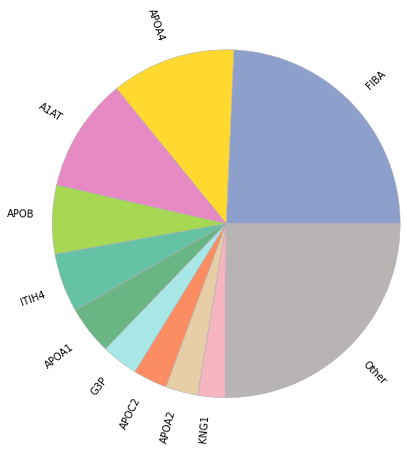

In [44]:
folder='peptide_sample_ninf'
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
df = df.drop(['HBB','HBA','HBD'])

tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)


ninf_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
pie=plt.pie(list(df_list_imp),labels = keys , wedgeprops=wp, rotatelabels=True, colors=ninf_colors, radius=2 )


# S2 Spectral count barcharts
### s.2.1 Without cutoff

Number of peptides in peptide _WF1.xlsx: 811
Number of peptides in peptide_WF2.xlsx: 934
Number of peptides in peptide_WF3.xlsx: 900
Number of peptides in peptide_WF4.xlsx: 572
Number of peptides in peptide_WF5.xlsx: 846
Number of peptides in peptide_sample_13.xlsx: 264
Number of peptides in peptide_sample_21.xlsx: 433
Number of peptides in peptide_sample_33.xlsx: 756
Number of peptides in peptide_sample_31.xlsx: 884
Number of peptides in peptide_sample_34.xlsx: 196
Number of peptides in peptide_sample_39.xlsx: 1056


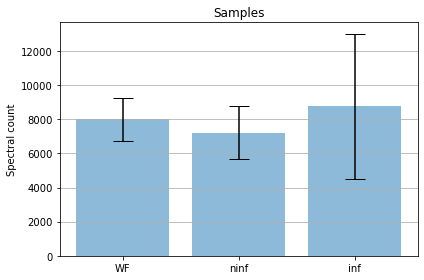

In [49]:
mapp='peptide_sample_WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
WF_samples=[]
WF_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    WF_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_WF = df_WF.append(data)  # appends all data
    print("Number of peptides in "+file+': '+str(len(data['Peptide'])))
    WF_samples_CO.append(data[['Peptide','#Feature']])

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
ninf_samples=[]
ninf_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    ninf_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_ninf = df_ninf.append(data)  # appends all data
    print("Number of peptides in "+file+': '+str(len(data['Peptide'])))
    ninf_samples_CO.append(data[['Peptide','#Feature']])

mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
inf_samples=[]
inf_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    inf_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_inf = df_inf.append(data)  # appends all data
    print("Number of peptides in "+file+': '+str(len(data['Peptide'])))
    inf_samples_CO.append(data[['Peptide','#Feature']])

df_ninf['count'] = 1
df_WF['count'] = 1
df_inf['count']=1

sum_WF_samples=[sum(WF_samples[0]['#Feature']),sum(WF_samples[1]['#Feature']),sum(WF_samples[2]['#Feature']),sum(WF_samples[3]['#Feature']),sum(WF_samples[4]['#Feature'])]
WF_samples_std=np.std(sum_WF_samples)
sum_ninf_samples=[sum(ninf_samples[0]['#Feature']),sum(ninf_samples[1]['#Feature']),sum(ninf_samples[2]['#Feature'])]
ninf_samples_std=np.std(sum_ninf_samples)
sum_inf_samples=[sum(inf_samples[0]['#Feature']),sum(inf_samples[1]['#Feature']),sum(inf_samples[2]['#Feature'])]
inf_samples_std=np.std(sum_inf_samples)

mean_WF_samples = np.mean(sum_WF_samples)
mean_inf_samples = np.mean(sum_inf_samples )
mean_ninf_samples = np.mean(sum_ninf_samples)

fig, ax = plt.subplots()

samples = ['Acute', 'Non-infected', 'Infected']
x_pos = np.arange(len(samples))
CTEs = [mean_WF_samples, mean_ninf_samples, mean_inf_samples]
error = [WF_samples_std, ninf_samples_std, inf_samples_std]

ax.bar(samples, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Spectral count')
ax.set_xticks(x_pos)
ax.set_xticklabels(samples)
ax.set_title('Samples')
ax.yaxis.grid(True)


plt.tight_layout()
plt.show()

### S.2.2 With cutoff

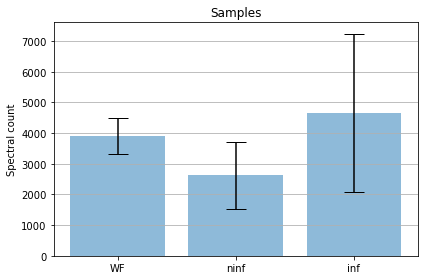

In [50]:
sum_WF_samples_CO=[sum(WF_samples_CO[0]['#Feature']),sum(WF_samples_CO[1]['#Feature']),sum(WF_samples_CO[2]['#Feature']),sum(WF_samples_CO[3]['#Feature']),sum(WF_samples_CO[4]['#Feature'])]
WF_samples_CO_std=np.std(sum_WF_samples_CO)
sum_inf_samples_CO=[sum(inf_samples_CO[0]['#Feature']),sum(inf_samples_CO[1]['#Feature']),sum(inf_samples_CO[2]['#Feature'])]
inf_samples_CO_std=np.std(sum_inf_samples_CO)
inf_samples_CO_std
sum_ninf_samples_CO=[sum(ninf_samples_CO[0]['#Feature']),sum(ninf_samples_CO[1]['#Feature']),sum(ninf_samples_CO[2]['#Feature'])]
ninf_samples_CO_std=np.std(sum_ninf_samples_CO)
ninf_samples_CO_std
mean_WF_samples_CO = np.mean(sum_WF_samples_CO)
mean_inf_samples_CO = np.mean(sum_inf_samples_CO)
mean_ninf_samples_CO = np.mean(sum_ninf_samples_CO)

fig, ax = plt.subplots()
samples = ['Acute', 'Non-infected', 'Infected']
x_pos = np.arange(len(samples))
CTEs = [mean_WF_samples_CO, mean_ninf_samples_CO, mean_inf_samples_CO]
error = [WF_samples_CO_std, ninf_samples_CO_std, inf_samples_CO_std]

ax.bar(samples, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Spectral count')
ax.set_xticks(x_pos)
ax.set_xticklabels(samples)
ax.set_title('Samples')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()